In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax.lax import scan, while_loop
from functools import partial

In [2]:
# Load data
dat = np.load('201118_cell1_A.npy', allow_pickle=True).item()
stimuli = dat['stimuli']
L_true = stimuli[:, :3]
I_true = stimuli[:, -1]
y_true = np.trapz(dat['responses'])

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
def get_psf_func(grid, z0=63, omega0=13, I_th=18):
    """Generate PSF.
    """
    def S_0(r, z, z0, omega0):
        return jnp.exp(-2*r**2/omega0**2) * jnp.exp(-2*z**2/z0**2)

    def S_S(r, z, I0, I_th, z0, omega0):
        alpha = jax.nn.relu(I0**2 - I_th**2)/I0**2
        zS = jnp.sqrt(alpha * z0**2 + 1e-8)
        omegaS = jnp.sqrt(alpha * omega0**2 + 1e-8)
        return jnp.exp(-2*r**2/omegaS**2) * jnp.exp(-2*z**2 / zS**2)

    def Se(r, z, I, I_th=I_th, z0=z0, omega0=omega0):
        Is = jnp.sqrt(jax.nn.relu(I**2 - I_th**2))
        return (I**2 * S_0(r, z, z0, omega0) - (I > I_th) * Is**2 * S_S(r, z, I, I_th, z0, omega0))/I_th**2

    def dist_euclid(vec1, vec2):
        return jnp.sqrt(jnp.sum(jnp.square(vec1 - vec2), 1))

    def dist_euclid_1d(vec1, vec2):
        return jnp.abs(vec1 - vec2)

    def _psf(g, I, center, I_th=I_th, z0=z0, omega0=omega0):
        return Se(dist_euclid(g[:, :2], center[:2]), dist_euclid_1d(g[:, -1], center[-1]), I, z0=z0, omega0=omega0, I_th=I_th)
    
    return jit(vmap(partial(_psf, grid), in_axes=(0, 0)))

In [5]:
def get_filt_grid_around_loc(loc, dim=20, num_points=4):
    xr, yr, zr = [np.linspace(loc[i] - dim/2, loc[i] + dim/2, num_points) for i in range(3)]
    xgrid, ygrid, zgrid = np.meshgrid(xr, yr, zr)
    return np.c_[xgrid.flatten(), ygrid.flatten(), zgrid.flatten()]

In [6]:
powers = np.arange(10, 51, 10.)

In [13]:
N = 7
num_points = 4
cell_spacing = 10
cell_locs = np.random.uniform(0, N*cell_spacing, [N, 3])
cell_grids = np.array([get_filt_grid_around_loc(cell_locs[n], num_points=num_points) for n in range(N)])
cell_psfs = [get_psf_func(cell_grids[n]) for n in range(N)]

In [14]:
sigmoid = lambda x: 1/(1 + np.exp(-x))

In [15]:
K = 2000
L = cell_locs[np.random.choice(N, K, replace=True)] + np.random.normal(0, 1, [K, 3])
I = np.random.choice(powers, K)

In [16]:
def get_gauss_func(grid):
    def _gauss(g, mu, Sigma):
        return jnp.exp(-(g - mu) @ Sigma @ (g - mu))
    return jit(partial(vmap(_gauss, in_axes=(0, None, None)), grid))

In [17]:
test_gauss = get_gauss_func(cell_grids[0])
true_filts = np.c_[np.array([jax.nn.relu(get_gauss_func(cell_grids[n])(cell_locs[n], 1e-2*jnp.eye(3)) + np.random.normal(0, 0.1, num_points**3)) for n in range(N)]), 4 + 3*np.random.rand(N)]

dropout_prob = 0.5
mask = 1.0 - (np.random.rand(true_filts.shape[0], true_filts.shape[1]) <= dropout_prob)
mask[:, -1] = 1.0

true_filts *= mask

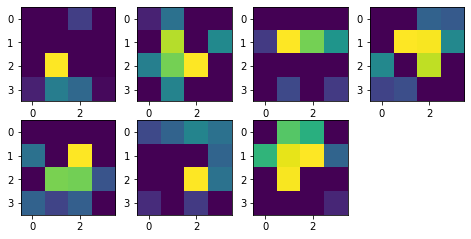

In [18]:
plt.figure(figsize=(8, 8))
for n in range(N):
    plt.subplot(4, 4, n+1)
    plt.imshow(true_filts[n][:-1].reshape([num_points]*3)[..., 2], vmin=0)
plt.show()
# plt.colorbar()

In [19]:
dim_extrema = [(np.min(cell_locs[:, i]), np.max(cell_locs[:, i])) for i in range(3)]

In [20]:
xr, yr, zr = np.arange(0, 101, 5), np.arange(0, 101, 5), np.arange(0, 101, 25)
dims = [len(arr) for arr in [xr, yr, zr]]
xgrid, ygrid, zgrid = np.meshgrid(xr, yr, zr)
grid = np.c_[xgrid.flatten(), ygrid.flatten(), zgrid.flatten()]

In [21]:
panel_size = 1.5
test_powers = [10, 25, 50]

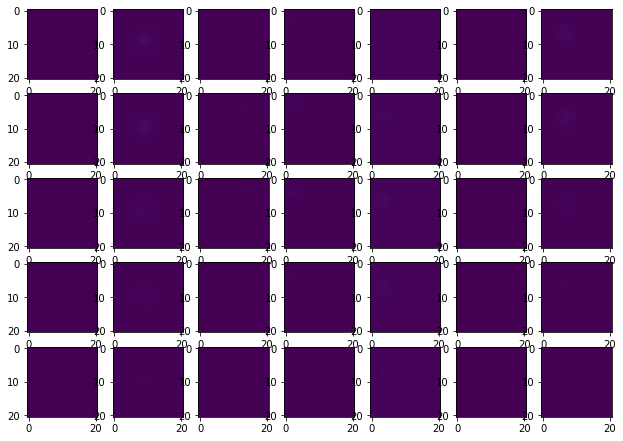

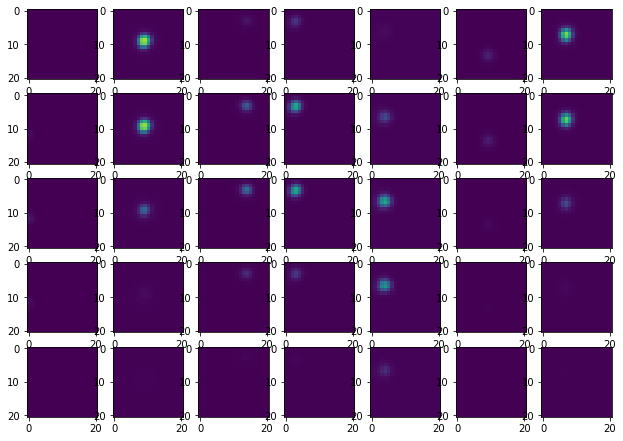

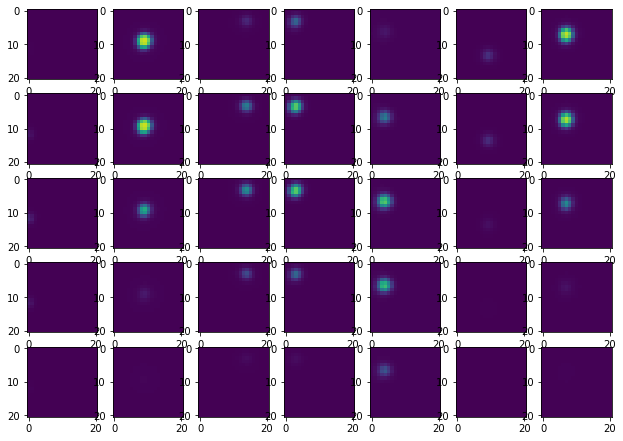

In [22]:
for power in test_powers:
    true_lam = sigmoid(np.array([np.c_[cell_psfs[n](power*np.ones(len(grid)), grid), -1 * np.ones(len(grid))] @ true_filts[n] for n in range(N)]))
    plt.figure(figsize=(panel_size * N, panel_size * dims[-1]))
    plot_cntr = 1
    for i in range(5):
        for n in range(N):
            plt.subplot(dims[-1], N, plot_cntr)
            plt.imshow(true_lam[n].reshape(dims)[..., i], vmin=0, vmax=1)
            plot_cntr += 1
    plt.show()

In [23]:
print(stim[n])

[[ 2.70554881e-01  2.79005904e-01  2.78453286e-01 ...  3.32018858e-01
   3.21003593e-01 -1.00000000e+00]
 [ 6.18369498e-02  6.24057736e-02  6.06785890e-02 ...  5.59425194e-03
   5.21476629e-03 -1.00000000e+00]
 [ 9.81036847e-02  8.99409979e-02  7.92120447e-02 ...  4.61615667e-08
   3.82496245e-08 -1.00000000e+00]
 ...
 [ 1.61102446e-01  1.55304778e-01  1.43158208e-01 ...  2.78556988e-06
   2.45521340e-06 -1.00000000e+00]
 [ 1.88326719e-02  1.67845548e-02  1.43039169e-02 ...  4.09627160e-09
   3.33796024e-09 -1.00000000e+00]
 [ 3.00839372e-01  3.11732188e-01  3.12491950e-01 ...  2.48592137e-01
   2.40824929e-01 -1.00000000e+00]]


In [24]:
stim = np.array([np.c_[cell_psfs[n](I, L), -np.ones(K)] for n in range(N)])
lam = sigmoid(np.array([stim[n] @ true_filts[n] for n in range(N)]))

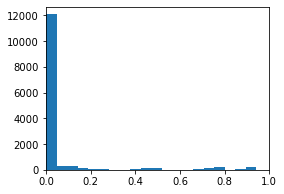

In [25]:
plt.figure(figsize=(4, 3))
plt.hist(lam.flatten(), 20)
plt.xlim([0, 1])
plt.show()

In [26]:
spks = (np.random.rand(N, K) <= lam).astype(float)

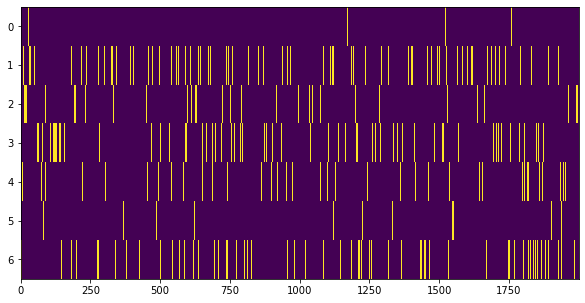

In [27]:
plt.figure(figsize=(10, 5))
plt.imshow(spks, aspect='auto', interpolation='nearest')
plt.show()

In [69]:
vlaplace = jit(vmap(laplace_approx, (0, 0, 0, 0)))

In [29]:

@jit
def laplace_approx(y, filt_prior, filt_cov, psfc, newton_steps=15, t=1e1, backtrack_alpha=0.25, backtrack_beta=0.5, max_backtrack_iters=40):
    """Laplace approximation to filter posteriors eta.
    """
    @jit
    def backtrack_cond(carry):
        it, _, lhs, rhs, _, _, _ = carry
        return jnp.logical_and(it < max_backtrack_iters, jnp.logical_or(jnp.isnan(lhs), lhs > rhs))

    @jit
    def backtrack(carry):
        it, step, lhs, rhs, v, J, filt = carry
        it += 1
        step *= backtrack_beta
        lhs, rhs = get_ineq(y, filt, step, v, psfc, t, J, backtrack_alpha)
        return (it, step, lhs, rhs, v, J, filt)

    @jit
    def get_ineq(y, filt, step, v, psfc, t, J, backtrack_alpha):
        return negloglik_with_barrier(y, filt + step * v, filt_prior, psfc, prior_prec, t), negloglik_with_barrier(y, filt, filt_prior, psfc, prior_prec, t) + backtrack_alpha * step * J @ v

    @jit
    def get_stepv(filt, t):
        lam = jax.nn.sigmoid(psfc @ filt)
        J = (lam - y) @ psfc - 1/(t * filt) + prior_prec @ (filt - filt_prior) 
        H = jnp.einsum('ij,ik->jk', (lam * (1 - lam))[:, None] * psfc, psfc) + jnp.diag(1/(t*filt**2)) + prior_prec
        H_inv = jnp.linalg.inv(H)
        v = -H_inv @ J
        return v, J, H_inv

    @jit
    def newton_step(filt_carry, _):
        filt, _ = filt_carry
        v, J, cov = get_stepv(filt, t)  
        step = 1.
        lhs, rhs = get_ineq(y, filt, step, v, psfc, t, J, backtrack_alpha)
        init_carry = (0, step, lhs, rhs, v, J, filt)
        carry = while_loop(backtrack_cond, backtrack, init_carry)
        _, step, lhs, _, _, _, _ = carry
        filt += step * v
        return (filt, cov), lhs

    key = jax.random.PRNGKey(1)
    filt = jax.random.uniform(key, shape=[psfc.shape[1]])
    prior_prec = jnp.linalg.inv(filt_cov)
    newton_steps = 30
    filt_carry = (filt, jnp.zeros((filt.shape[0], filt.shape[0])))
    return scan(newton_step, filt_carry, jnp.arange(newton_steps))

@jit
def negloglik_with_barrier(y, filt, filt_prior, psfc, prec, t):
    lam = jax.nn.sigmoid(psfc @ filt)
    return -jnp.sum(jnp.nan_to_num(y * jnp.log(lam) + (1 - y) * jnp.log(1 - lam))) - jnp.sum(jnp.log(filt))/t + 1/2 * (filt - filt_prior) @ prec @ (filt - filt_prior)


In [ ]:
# @jit
# def negloglik_with_barrier(y, filt, psfc, prec, t):
#     lam = jax.nn.sigmoid(psfc @ filt)
#     return -jnp.sum(jnp.nan_to_num(y * jnp.log(lam + 1e-13) + (1 - y) * jnp.log(1 - lam + 1e-13))) - jnp.sum(jnp.log(filt))/t + 1/2 * filt @ prec @ filt

# @jit
# def laplace_approx(y, psfc, filt_cov, niters=30, t=1e1, backtrack_alpha=0.25, backtrack_beta=0.5, max_backtrack_iters=25):
    
#     @jit
#     def backtrack_cond(carry):
#         it, _, lhs, rhs, _, _, _ = carry
#         return jnp.logical_and(it < max_backtrack_iters, jnp.logical_or(jnp.isnan(lhs), lhs > rhs))

#     @jit
#     def backtrack(carry):
#         it, step, lhs, rhs, v, J, filt = carry
#         it += 1
#         step *= backtrack_beta
#         lhs, rhs = get_ineq(y, filt, step, v, psfc, t, J, backtrack_alpha)
#         return (it, step, lhs, rhs, v, J, filt)
    
#     @jit
#     def get_ineq(y, filt, step, v, psfc, t, J, backtrack_alpha):
#         return negloglik_with_barrier(y, filt + step * v, psfc, prior_prec, t), negloglik_with_barrier(y, filt, psfc, prior_prec, t) + backtrack_alpha * step * J @ v

#     @jit
#     def get_stepv(filt, t):
#         lam = jax.nn.sigmoid(psfc @ filt)
#         J = (lam - y) @ psfc - 1/(t * filt) + prior_prec @ filt 
#         H = jnp.einsum('ij,ik->jk', (lam * (1 - lam))[:, None] * psfc, psfc) + jnp.diag(1/(t*filt**2)) + prior_prec
#         H_inv = jnp.linalg.inv(H)
#         v = -H_inv @ J
#         return v, J, H_inv
    
#     @jit
#     def newton_step(filt_posterior, _):
#         filt, _ = filt_posterior
#         v, J, cov = get_stepv(filt, t)  
#         step = 1.
#         lhs, rhs = get_ineq(y, filt, step, v, psfc, t, J, backtrack_alpha)
#         init_carry = (0, step, lhs, rhs, v, J, filt)
#         carry = while_loop(backtrack_cond, backtrack, init_carry)
#         _, step, lhs, _, _, _, _ = carry
#         filt += step * v
#         return (filt, cov), lhs
    
#     key = jax.random.PRNGKey(1)
#     filt = jax.random.uniform(key, shape=[psfc.shape[1]])
#     prior_prec = jnp.linalg.inv(filt_cov)
#     filt_prior = (filt, filt_cov)
#     return scan(newton_step, filt_prior, jnp.arange(niters))

In [44]:
prior_variance = 1e0
filt_cov = np.array([prior_variance * jnp.eye(true_filters.shape[1]) for _ in range(N)])
filt_prior = np.zeros((N, true_filters.shape[1]))
filt_prior[:, -1] = 5

In [86]:
posterior, logliks = vlaplace(spks, filt_prior, filt_cov, stim)

In [87]:
posterior

(DeviceArray([[0.1396866 , 0.13569197, 0.13484259, 0.13710476, 0.08098629,
               0.07893117, 0.07846769, 0.07954954, 0.07935036, 0.07748387,
               0.07702983, 0.07795217, 0.12298809, 0.1194792 , 0.11879996,
               0.1209259 , 0.10821088, 0.10481149, 0.10397729, 0.1056188 ,
               0.07521395, 0.07509216, 0.07486063, 0.07443819, 0.08268416,
               0.08275424, 0.08242019, 0.08160633, 0.10268081, 0.10029091,
               0.09953863, 0.10038831, 0.15475137, 0.14910584, 0.14755626,
               0.14994043, 0.08702997, 0.08536496, 0.085056  , 0.08593839,
               0.09672175, 0.09493649, 0.09453367, 0.09530061, 0.1461112 ,
               0.14225892, 0.1408547 , 0.14184216, 0.32361581, 0.31933716,
               0.3165872 , 0.31553542, 0.24005534, 0.23130365, 0.22842059,
               0.23120717, 0.23452841, 0.22677775, 0.22396157, 0.22594225,
               0.28729099, 0.28323975, 0.28103559, 0.28081342, 6.69074484],
              [0.1065101

In [81]:
out[0][0].shape

(7, 65)

In [82]:
out[0][1].shape

(7, 65, 65)

In [83]:
out[0]

(DeviceArray([[0.1396866 , 0.13569197, 0.13484259, 0.13710476, 0.08098629,
               0.07893117, 0.07846769, 0.07954954, 0.07935036, 0.07748387,
               0.07702983, 0.07795217, 0.12298809, 0.1194792 , 0.11879996,
               0.1209259 , 0.10821088, 0.10481149, 0.10397729, 0.1056188 ,
               0.07521395, 0.07509216, 0.07486063, 0.07443819, 0.08268416,
               0.08275424, 0.08242019, 0.08160633, 0.10268081, 0.10029091,
               0.09953863, 0.10038831, 0.15475137, 0.14910584, 0.14755626,
               0.14994043, 0.08702997, 0.08536496, 0.085056  , 0.08593839,
               0.09672175, 0.09493649, 0.09453367, 0.09530061, 0.1461112 ,
               0.14225892, 0.1408547 , 0.14184216, 0.32361581, 0.31933716,
               0.3165872 , 0.31553542, 0.24005534, 0.23130365, 0.22842059,
               0.23120717, 0.23452841, 0.22677775, 0.22396157, 0.22594225,
               0.28729099, 0.28323975, 0.28103559, 0.28081342, 6.69074484],
              [0.1065101

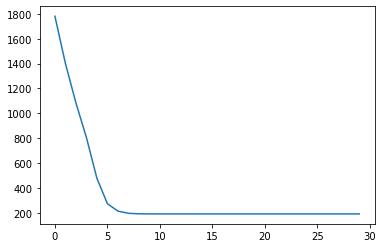

In [79]:
plt.plot(out[1][2])

In [72]:
%time run_la()[-1].block_until_ready()

CPU times: user 3.74 s, sys: 8.66 s, total: 12.4 s
Wall time: 804 ms


DeviceArray([0.12439199, 0.11342018, 0.10412869, 0.0967381 , 0.16087517,
             0.16072396, 0.15846142, 0.15424174, 0.17986085, 0.18534032,
             0.18934948, 0.19136426, 0.17236055, 0.17241968, 0.17458939,
             0.17875976, 0.10509987, 0.09836231, 0.09147199, 0.08513594,
             0.38812494, 0.4161465 , 0.4081261 , 0.36749955, 0.26313435,
             0.28343282, 0.28778947, 0.27860227, 0.07615832, 0.07601295,
             0.07691759, 0.07886241, 0.1160094 , 0.1125836 , 0.10772029,
             0.10204803, 0.40410867, 0.44806212, 0.44635865, 0.40194285,
             0.11100931, 0.11371833, 0.11539962, 0.1164126 , 0.04904744,
             0.04967124, 0.05014039, 0.05038119, 0.14435133, 0.14198676,
             0.14078655, 0.14070462, 0.12274028, 0.12429237, 0.12577461,
             0.12709006, 0.05714119, 0.05679241, 0.05719975, 0.05835524,
             0.04534507, 0.04520168, 0.04532895, 0.04572134, 4.83148381],            dtype=float64)

In [65]:
def run_la():
    est_filts = [None] * len(true_filts)    
    for n in range(N):
        filt_posterior, nlls = laplace_approx(spks[n], filt_prior[n], filt_cov[n], stim[n], t=1e1)
        tmp_filt, _ = filt_posterior
        est_filts[n] = tmp_filt
        
    return est_filts

#     plt.figure(figsize=(2, 2))
#     plt.plot(nlls, 'o-')
#     plt.show()
#     tmp_filt, _ = filt_posterior
#     est_filts[n] = tmp_filt

In [38]:
vmax = np.max([np.max(est_filts[:, :-1]), np.max(true_filts[:, :-1])])
vmin = np.min([np.min(est_filts[:, :-1]), np.min(true_filts[:, :-1])])

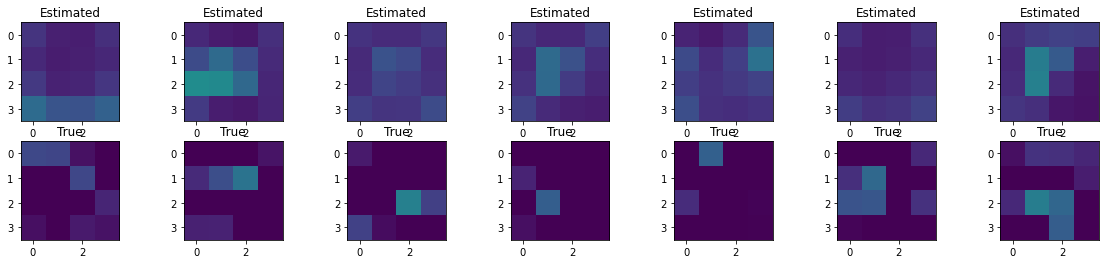

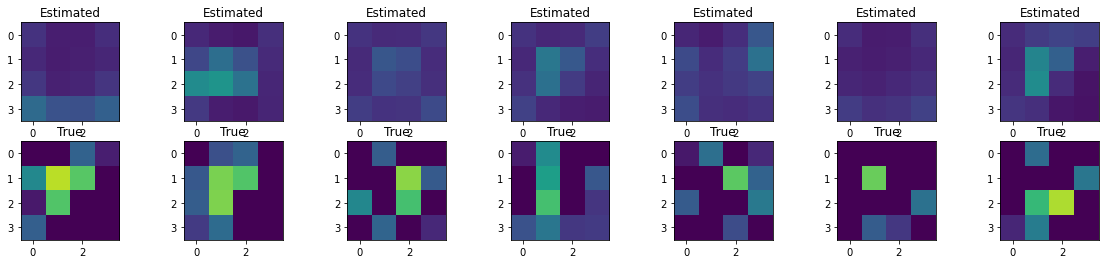

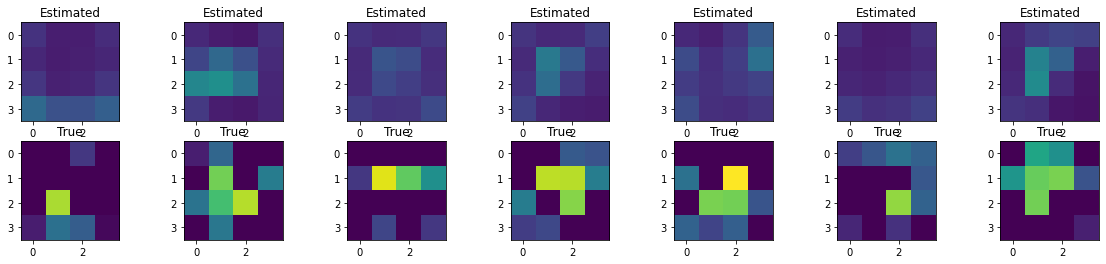

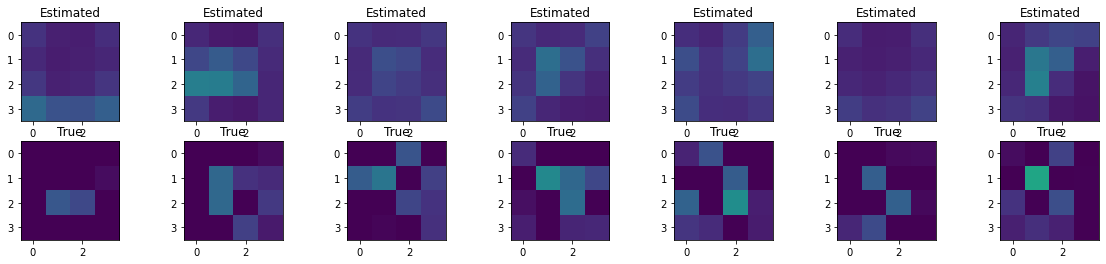

In [39]:
for d in range(num_points):
    plt.figure(figsize=(20, 4))
    plt_cntr = 1
    for n in range(N):
        plt.subplot(2, N, plt_cntr)
        plt.title('Estimated')
        plt.imshow(est_filts[n][:-1].reshape([num_points]*3)[..., d], vmin=vmin, vmax=vmax)
        plt_cntr += 1
    for n in range(N):
        plt.subplot(2, N, plt_cntr)
        plt.title('True')
        plt.imshow(true_filts[n][:-1].reshape([num_points]*3)[..., d], vmin=vmin, vmax=vmax)
        plt_cntr += 1

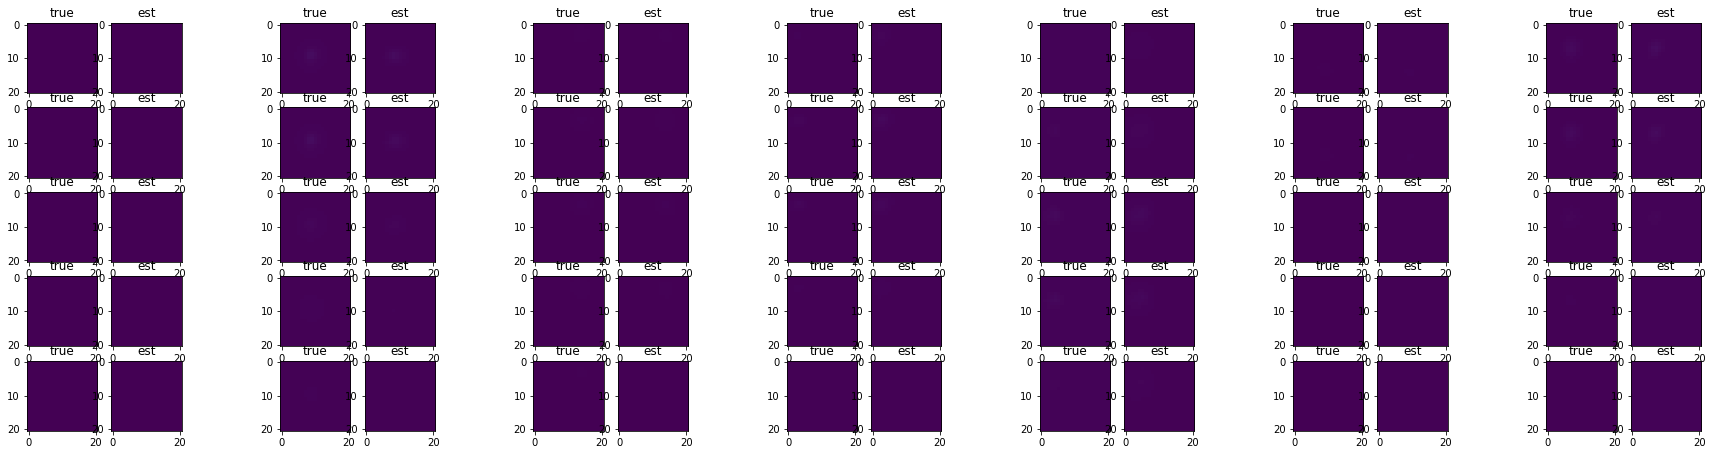

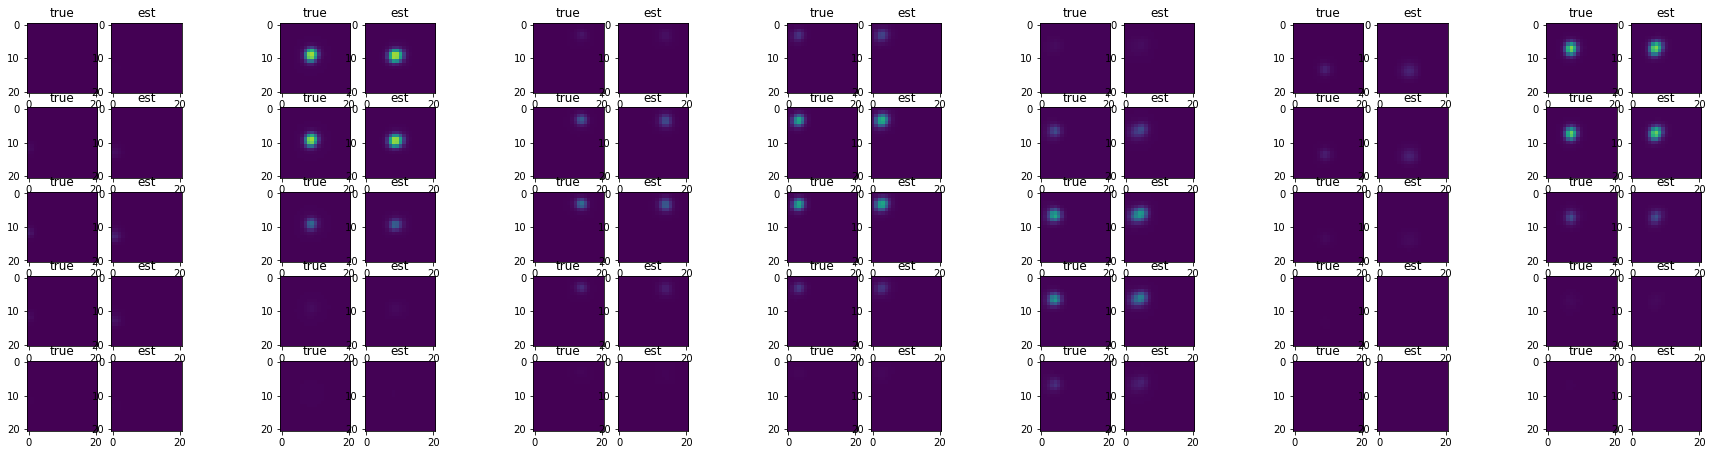

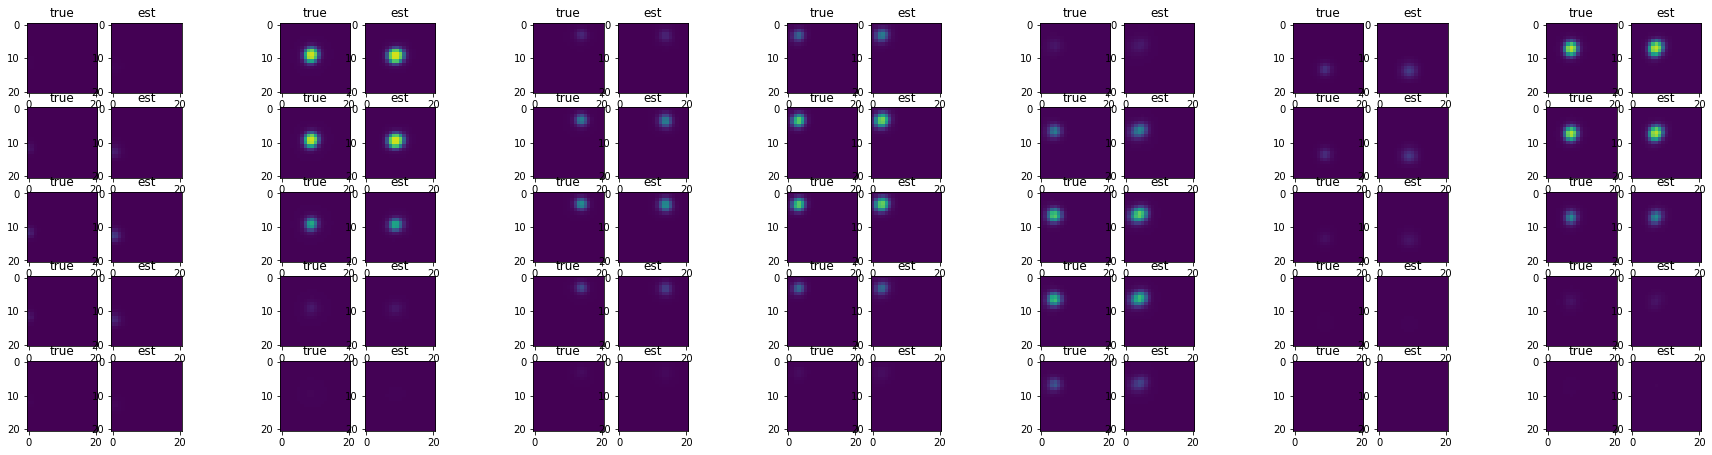

In [40]:
for power in test_powers:
    test_lam = sigmoid(np.array([np.c_[cell_psfs[n](power*np.ones(len(grid)), grid), -1 * np.ones(len(grid))] @ est_filts[n] for n in range(N)]))
    true_lam = sigmoid(np.array([np.c_[cell_psfs[n](power*np.ones(len(grid)), grid), -1 * np.ones(len(grid))] @ true_filts[n] for n in range(N)]))
    plt.figure(figsize=(panel_size * N * 3 - panel_size, panel_size * dims[-1]))
    plot_cntr = 1
    for i in range(5):
        for n in range(N):
            plt.subplot(dims[-1], N * 3 - 1, plot_cntr)
            plt.title('true')
            plt.imshow(true_lam[n].reshape(dims)[..., i], vmin=0, vmax=1)
            plot_cntr += 1
            
            plt.subplot(dims[-1], N * 3 - 1, plot_cntr)
            plt.title('est')
            plt.imshow(test_lam[n].reshape(dims)[..., i], vmin=0, vmax=1)
            plot_cntr += 1
            
            if n < N - 1:
                plt.subplot(dims[-1], N * 3 - 1, plot_cntr)
                plt.axis('off')
                plot_cntr += 1
            
    plt.show()